### Phase 1: Setup & Data Acquisition (The "ET" in ETL)

**Goal:** Collect the Billboard Year-End charts and lyrics into a usable dataset.



**Task 1.1: GitHub Repo Setup**

  * Create a public repo.
  * Include a `.gitignore` file for any API tokens.
  * *Satisfies: Reproducible code.*


**Task 1.2: Scrape Billboard Data (The "Skeleton")**

  * Use `BeautifulSoup` or `pandas.read_html` to scrape Year-End Hot 100 for 2013–2023.
  * Extract: Rank, Song Title, Artist.
  * *Satisfies: Data Source #1.*
    * *Scrape is skipped if CSV already exists*

In [12]:
# ==========================================
# Billboard Year-End Hot 100 Scraper (FINAL)
# ==========================================

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from pathlib import Path

# -------------------------------
# 1. SCRAPE CONFIGURATION
# -------------------------------
YEARS = range(2013, 2024)
OUTPUT_FILE = "billboard_hot_100_2013_2023.csv"

HEADERS = {
    "User-Agent": (
        "Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
        "AppleWebKit/537.36 (KHTML, like Gecko) "
        "Chrome/120.0 Safari/537.36"
    )
}

# -------------------------------
# 2. SKIP SCRAPING IF CSV EXISTS
# -------------------------------
if Path(OUTPUT_FILE).exists():
    print(f"Found existing file '{OUTPUT_FILE}'. Loading cached data...")
    df_billboard = pd.read_csv(OUTPUT_FILE)

else:
    print("Starting Billboard scraping process...")
    all_songs = []

    # -------------------------------
    # 3. SCRAPE LOOP
    # -------------------------------
    for year in YEARS:
        url = f"https://www.billboard.com/charts/year-end/{year}/hot-100-songs/"
        print(f"Scraping year: {year}")

        try:
            response = requests.get(url, headers=HEADERS, timeout=15)

            if response.status_code != 200:
                print(f"Failed to retrieve {year}: HTTP {response.status_code}")
                continue

            soup = BeautifulSoup(response.content, "html.parser")

            # Each chart row container
            chart_items = soup.find_all(
                "div",
                class_="o-chart-results-list-row-container"
            )

            for item in chart_items:
                # Rank
                rank_span = item.find("span", class_="c-label")
                rank = rank_span.get_text(strip=True) if rank_span else None

                # Title
                title_h3 = item.find("h3", id="title-of-a-story")
                title = title_h3.get_text(strip=True) if title_h3 else None

                # Artist
                artist_span = (
                    title_h3.find_next_sibling("span", class_="c-label")
                    if title_h3 else None
                )
                artist = artist_span.get_text(strip=True) if artist_span else None

                all_songs.append({
                    "Rank": rank,
                    "Year": year,
                    "Title": title,
                    "Artist": artist
                })

            # Polite delay to avoid hammering the site
            time.sleep(1)

        except Exception as e:
            print(f"Error scraping {year}: {e}")

    # -------------------------------
    # 4. DATAFRAME CREATION
    # -------------------------------
    df_billboard = pd.DataFrame(all_songs)

    # -------------------------------
    # 5. DATA CLEANING
    # -------------------------------
    df_billboard['Rank'] = pd.to_numeric(
        df_billboard['Rank'], errors='coerce'
    )

    # -------------------------------
    # 6. SAVE FOR REPRODUCIBILITY
    # -------------------------------
    df_billboard.to_csv(OUTPUT_FILE, index=False)
    print(f"Scraping complete. Saved {len(df_billboard)} rows to '{OUTPUT_FILE}'")

# -------------------------------
# 7. QUICK VALIDATION
# -------------------------------
print(f"Total songs loaded: {len(df_billboard)}")
df_billboard.head()


Found existing file 'billboard_hot_100_2013_2023.csv'. Loading cached data...
Total songs loaded: 1099


,Rank,Year,Title,Artist
0,1,2013,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz
1,2,2013,Blurred Lines,Robin ThickeFeaturing T.I. + Pharrell
2,3,2013,Radioactive,Imagine Dragons
3,4,2013,Harlem Shake,Baauer
4,5,2013,Can't Hold Us,Macklemore & Ryan Lewis FeaturingRay Dalton


**Skipped:**

**Task 1.3: Spotify API Integration (The "Audio Features")**
   * Register for a Spotify Developer account to get a Client ID/Secret.
   * Use the `spotipy` library.
   * Loop through your Billboard list to search for the Track ID, then fetch Audio Features (Valence, Energy).
   * *Satisfies: Data Source #2 (Web API).*

**Challenges faced:**

   * Spotify Audio Features API depreciated in June of 2025
   * Pivoted to Soundnet Track Analysis API (uses Spotify Track IDs)
      * Encountered rate limits when calling more than 1 song at a time

**Commented code is included below for demonstration purposes.

**Utilized OAuth2 (new tool)


In [13]:
# # =======================================
# # Spotify Audio Features (using Bearer Token)
# # =======================================
#
# import os
# import re
# import time
# import pandas as pd
# import requests
#
# # -------------------------------
# # 1. CONFIGURATION
# # -------------------------------
# # Manual access token (replace with your own if expired)
# access_token = ""
#
# headers = {
#     "Authorization": f"Bearer {access_token}"
# }
#
# # -------------------------------
# # 2. LOAD BILLBOARD DATA
# # -------------------------------
# billboard_df = pd.read_csv("billboard_hot_100_2013_2023.csv")
#
# # Ensure Spotify_ID column exists or was filled in a previous step
# if "Spotify_ID" not in billboard_df.columns:
#     raise ValueError("You must have a 'Spotify_ID' column for each track.")
#
# # -------------------------------
# # 3. HELPER FUNCTIONS
# # -------------------------------
# def clean_artist_name(artist):
#     """Clean artist names to improve search accuracy."""
#     return re.split(r' Featuring | feat\. | ft\. | & | x |,', artist, flags=re.I)[0].strip()
#
# def fetch_audio_features(track_id, title, artist):
#     """Fetch audio features using manual Bearer token."""
#     url = f"https://api.spotify.com/v1/audio-features/{track_id}"
#
#     try:
#         response = requests.get(url, headers=headers)
#         if response.status_code == 200:
#             data = response.json()
#             return [
#                 data.get("valence"),
#                 data.get("energy"),
#                 data.get("mode"),
#                 track_id
#             ]
#         else:
#             print(f"Error {response.status_code} for '{title}' by '{artist}'")
#             return [None, None, None, track_id]
#
#     except Exception as e:
#         print(f"Unexpected error for '{title}' by '{artist}': {e}")
#         return [None, None, None, track_id]
#
# # -------------------------------
# # 4. RUN API CALLS (SAFE LOOP)
# # -------------------------------
# print("Starting Spotify audio feature retrieval...")
#
# results = []
#
# for idx, row in billboard_df.iterrows():
#     track_id = row["Spotify_ID"]
#     title = row["Title"]
#     artist = row["Artist"]
#
#     results.append(fetch_audio_features(track_id, title, artist))
#     time.sleep(0.2)  # polite throttle
#
#     if idx % 50 == 0 and idx > 0:
#         print(f"Processed {idx} songs...")
#
# # -------------------------------
# # 5. MERGE RESULTS
# # -------------------------------
# spotify_df = pd.DataFrame(
#     results,
#     columns=["Valence", "Energy", "Mode", "Spotify_ID"]
# )
#
# billboard_df = pd.merge(
#     billboard_df,
#     spotify_df,
#     on="Spotify_ID",
#     how="left"
# )
#
# # -------------------------------
# # 6. SAVE CLEAN DATA
# # -------------------------------
# billboard_df.to_csv("billboard_with_spotify_data.csv", index=False)
# print(f"Done! Saved {len(billboard_df)} rows to 'billboard_with_spotify_data.csv'")
#
#


**Skipped:**

**Task 1.3a: SoundNet Track Analysis API Integration (The "Emotional Data")**
   * Loop through Billboard list to search for the Track ID and append to new csv

**Commented code is included below for demonstration purposes.


In [14]:
# # =======================================
# # Spotify Track ID Retrieval for SoundNet
# # =======================================
#
# import os
# import re
# import time
# import pandas as pd
# from spotipy import Spotify
# from spotipy.oauth2 import SpotifyClientCredentials
# from dotenv import load_dotenv
#
# # -------------------------------
# # 1. LOAD ENV VARIABLES & AUTHENTICATE
# # -------------------------------
# load_dotenv()  # loads SPOTIFY_CLIENT_ID and SPOTIFY_CLIENT_SECRET
#
# client_id = os.getenv("SPOTIFY_CLIENT_ID")
# client_secret = os.getenv("SPOTIFY_CLIENT_SECRET")
#
# if not client_id or not client_secret:
#     raise ValueError("Spotify credentials not found in environment variables.")
#
# auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
# sp = Spotify(auth_manager=auth_manager)
#
# # -------------------------------
# # 2. LOAD BILLBOARD DATA
# # -------------------------------
# billboard_df = pd.read_csv("billboard_hot_100_2013_2023.csv")
#
# # -------------------------------
# # 3. HELPER FUNCTION
# # -------------------------------
# def clean_artist_name(artist):
#     """Remove featuring artists and extra text for better Spotify search accuracy."""
#     return re.split(r' Featuring | feat\. | ft\. | & | x |,', artist, flags=re.I)[0].strip()
#
# def get_spotify_id(title, artist):
#     """Search Spotify and return the track ID (or None if not found)."""
#     artist_clean = clean_artist_name(artist)
#     query = f"track:{title} artist:{artist_clean}"
#
#     try:
#         result = sp.search(q=query, type="track", limit=1)
#         items = result.get("tracks", {}).get("items", [])
#         if items:
#             return items[0]["id"]
#         return None
#     except Exception as e:
#         print(f"Error searching '{title}' by '{artist}': {e}")
#         return None
#
# # -------------------------------
# # 4. RUN TRACK ID RETRIEVAL
# # -------------------------------
# spotify_ids = []
#
# print("Fetching Spotify Track IDs...")
#
# for idx, row in billboard_df.iterrows():
#     title = row["Title"]
#     artist = row["Artist"]
#     track_id = get_spotify_id(title, artist)
#     spotify_ids.append(track_id)
#
#     # polite throttle
#     time.sleep(0.2)
#
#     if idx % 50 == 0 and idx > 0:
#         print(f"Processed {idx} songs...")
#
# billboard_df["Spotify_ID"] = spotify_ids
#
# # -------------------------------
# # 5. SAVE UPDATED CSV
# # -------------------------------
# billboard_df.to_csv("billboard_with_spotify_ids.csv", index=False)
# print(f"Done! Saved {len(billboard_df)} rows with Spotify IDs to 'billboard_with_spotify_ids.csv'")
#
# # -------------------------------
# # 6. QUICK CHECK
# # -------------------------------
# missing = billboard_df["Spotify_ID"].isna().sum()
# print(f"Missing Spotify IDs for {missing} songs")
# billboard_df.head()


**Skipped:**

**Task 1.3b: SoundNet Track Analysis API Integration (The "Emotional Data")**

* Register for an API client ID through RapidAPI
   * Use the SoundNet Track Analysis API to retrieve Valence, Energy, Mode
   * *Satisfies: Data Source #2 (Web API).*

**Commented code is included below for demonstration purposes.

In [15]:
# # =======================================
# # Track Analysis API Integration (FINAL)
# # =======================================
#
# import requests
# import time
# import pandas as pd
# import os
# from dotenv import load_dotenv
#
# # -------------------------------
# # 1. LOAD ENV VARIABLES
# # -------------------------------
# load_dotenv()
#
# RAPIDAPI_KEY = os.getenv("RAPIDAPI_KEY")
#
# if not RAPIDAPI_KEY:
#     raise ValueError("RAPIDAPI_KEY not found in environment variables.")
#
# HEADERS = {
#     "x-rapidapi-key": RAPIDAPI_KEY,
#     "x-rapidapi-host": "track-analysis.p.rapidapi.com"
# }
#
# BASE_URL = "https://track-analysis.p.rapidapi.com/pktx/spotify/"
#
# # -------------------------------
# # 2. LOAD BILLBOARD + SPOTIFY IDS
# # -------------------------------
# billboard_df = pd.read_csv("billboard_with_spotify_ids.csv")
#
# # Remove rows without Spotify IDs
# billboard_df = billboard_df.dropna(subset=["Spotify_ID"]).reset_index(drop=True)
#
# print(f"Processing {len(billboard_df)} tracks with valid Spotify IDs...")
#
# # -------------------------------
# # 3. FETCH AUDIO FEATURES
# # -------------------------------
# feature_rows = []
#
# for idx, row in billboard_df.iterrows():
#     spotify_id = row["Spotify_ID"]
#     url = f"{BASE_URL}{"spotify_id"}"
#
#     max_retries = 5
#     backoff = 1  # start with 1 second
#
#     for attempt in range(max_retries):
#         response = requests.get(url, headers=HEADERS)
#
#         if response.status_code == 200:
#             data = response.json()
#             feature_rows.append({
#                 "Spotify_ID": spotify_id,
#                 "Energy": data.get("energy"),
#                 "Valence": data.get("valence"),
#                 "Danceability": data.get("danceability"),
#                 "Tempo": data.get("tempo"),
#                 "Loudness": data.get("loudness")
#             })
#             break  # success, exit retry loop
#
#         elif response.status_code == 429:
#             print(f"Rate limit hit for {spotify_id}, retrying in {backoff}s...")
#             time.sleep(backoff)
#             backoff *= 2  # exponential backoff
#         else:
#             print(f"API error {response.status_code} for {spotify_id}")
#             feature_rows.append({
#                 "Spotify_ID": spotify_id,
#                 "Energy": None,
#                 "Valence": None,
#                 "Danceability": None,
#                 "Tempo": None,
#                 "Loudness": None
#             })
#             break
#
#     # small sleep between requests to avoid rate-limit
#     time.sleep(0.2)
#     if idx % 50 == 0 and idx > 0:
#         print(f"Processed {idx} tracks...")
#
# # -------------------------------
# # 4. MERGE FEATURES BACK
# # -------------------------------
# features_df = pd.DataFrame(feature_rows)
#
# final_df = billboard_df.merge(features_df, on="Spotify_ID", how="left")
#
# # -------------------------------
# # 5. SAVE FINAL DATASET
# # -------------------------------
# final_df.to_csv("billboard_with_audio_features.csv", index=False)
#
# print("Done!")
# print(f"Final dataset shape: {final_df.shape}")
# print(f"Missing Valence values: {final_df['Valence'].isna().sum()}")
# final_df.head()


**End Skipped**

**Task 1.3: Genius Lyrics (The "Sentiment")**
   * *Note:* Used the `lyricsgenius` library (wrapper) to make scraping task easier.
   * Fetch lyrics for the songs in your list.
   * *Satisfies: Strengthening the "New Feature" requirement.*

In [16]:
# ==========================================
# Genius Lyrics Acquisition (FINAL)
# ==========================================

import os
import time
import re
import pandas as pd
import lyricsgenius
from dotenv import load_dotenv
from pathlib import Path

# -------------------------------
# 1. AUTHENTICATION (via .env)
# -------------------------------
load_dotenv()

genius = lyricsgenius.Genius(
    os.getenv("GENIUS_ACCESS_TOKEN"),
    verbose=False,
    remove_section_headers=True,
    skip_non_songs=True
)

# -------------------------------
# 2. FILE CONFIGURATION
# -------------------------------
INPUT_FILE = "billboard_hot_100_2013_2023.csv"
OUTPUT_FILE = "billboard_with_lyrics.csv"

# -------------------------------
# 3. SKIP API IF CSV EXISTS
# -------------------------------
if Path(OUTPUT_FILE).exists():
    print(f"Found existing file '{OUTPUT_FILE}'. Loading cached lyrics...")
    df = pd.read_csv(OUTPUT_FILE)

else:
    # -------------------------------
    # 4. LOAD BILLBOARD DATA
    # -------------------------------
    df = pd.read_csv(INPUT_FILE)

    # -------------------------------
    # 5. HELPER FUNCTIONS
    # -------------------------------
    def clean_artist_name(artist):
        artist = re.split(
            r' Featuring | feat\. | ft\. | & | x |,',
            artist,
            flags=re.I
        )[0]
        return artist.strip()

    def fetch_lyrics(row):
        title = row['Title']
        artist = clean_artist_name(row['Artist'])

        try:
            song = genius.search_song(title, artist)
            time.sleep(1)  # Genius requires slower pacing

            if song and song.lyrics:
                return song.lyrics
            else:
                return None

        except Exception as e:
            print(f"Error fetching lyrics for '{title}': {e}")
            return None

    # -------------------------------
    # 6. RUN GENIUS LOOKUPS (SAFE LOOP)
    # -------------------------------
    print("Starting Genius lyrics retrieval...")
    lyrics = []

    for idx, row in df.iterrows():
        lyrics.append(fetch_lyrics(row))

        if idx % 25 == 0:
            print(f"Processed {idx} songs...")

    df['Lyrics'] = lyrics

    # -------------------------------
    # 7. SAVE FOR REPRODUCIBILITY
    # -------------------------------
    df.to_csv(OUTPUT_FILE, index=False)
    print(f"Lyrics saved to '{OUTPUT_FILE}'")

# -------------------------------
# 8. QUICK VALIDATION
# -------------------------------
missing = df['Lyrics'].isna().sum()
print(f"Songs missing lyrics: {missing}")
df[['Title', 'Artist', 'Lyrics']].head()


Found existing file 'billboard_with_lyrics.csv'. Loading cached lyrics...
Songs missing lyrics: 312


,Title,Artist,Lyrics
0,Thrift Shop,Macklemore & Ryan Lewis Featuring Wanz,"Hey, Macklemore, can we go thrift shopping?\nW..."
1,Blurred Lines,Robin ThickeFeaturing T.I. + Pharrell,NaN
2,Radioactive,Imagine Dragons,"Woah, oh, oh\nWoah, oh, oh\nWoah, oh, oh\nWoah..."
3,Harlem Shake,Baauer,"Con los terroristas, -tas, -tas, -tas\n-tas -t..."
4,Can't Hold Us,Macklemore & Ryan Lewis FeaturingRay Dalton,"Hey, hey, hey\nGood to see you\nCome on, dude,..."


### Phase 2: Transformation & Cleaning (The "T" in ETL)

**Goal:** Turn raw lyrics and metadata into a clean dataset ready for analysis.


**Task 2.1: Lyric Sentiment Analysis**

  * Use an NLP library not heavily covered in class (e.g., `TextBlob` or `NLTK` VADER) to calculate a sentiment score for each song.
  * Store the compound score (or polarity) as the “Lyric Sentiment” feature.
  * *Satisfies: “New feature not covered in class.”*


In [17]:
# ==================================
# Lyric Sentiment Analysis (FINAL)
# ==================================

import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# -------------------------------
# 1. LOAD DATA (WITH LYRICS)
# -------------------------------
# Use the CSV that already contains scraped lyrics
lyrics_df = pd.read_csv("billboard_with_lyrics.csv")

# -------------------------------
# 2. SETUP VADER SENTIMENT
# -------------------------------
nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

# -------------------------------
# 3. SENTIMENT FUNCTION
# -------------------------------
def analyze_lyrics_sentiment(lyrics):
    """
    Returns VADER sentiment scores for song lyrics.
    """
    if not isinstance(lyrics, str) or lyrics.strip() == "":
        return {
            "Lyric_Neg": None,
            "Lyric_Neu": None,
            "Lyric_Pos": None,
            "Lyric_Compound": None
        }

    scores = sid.polarity_scores(lyrics)
    return {
        "Lyric_Neg": scores['neg'],
        "Lyric_Neu": scores['neu'],
        "Lyric_Pos": scores['pos'],
        "Lyric_Compound": scores['compound']
    }

# -------------------------------
# 4. APPLY SENTIMENT ANALYSIS
# -------------------------------
print("Running lyric sentiment analysis...")

sentiment_scores = lyrics_df['Lyrics'].apply(analyze_lyrics_sentiment)
sentiment_df = pd.DataFrame(list(sentiment_scores))

lyrics_df = pd.concat([lyrics_df, sentiment_df], axis=1)

# -------------------------------
# 5. QUICK VALIDATION
# -------------------------------
print("Sentiment analysis complete.")
print(f"Songs without lyrics sentiment: {df['Lyric_Compound'].isna().sum()}")

df[['Lyrics', 'Lyric_Compound']].head()

# -------------------------------
# 6. SAVE PROCESSED DATA
# -------------------------------
lyrics_sentiment_df = lyrics_df.copy()
lyrics_sentiment_df.to_csv(
    "billboard_with_lyrics_and_sentiment.csv",
    index=False
)


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alexwaters/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Running lyric sentiment analysis...
Sentiment analysis complete.


KeyError: 'Lyric_Compound'

**Task 2.2: Merge and Clean Data**

  * Combine Billboard metadata with lyric sentiment scores into a single DataFrame.
  * Drop songs missing lyrics or sentiment scores if needed.
  * *Satisfies: Data analytics workflow.*


In [3]:
# -------------------------------
# 1. LOAD DATA
# -------------------------------

import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("billboard_with_lyrics_and_sentiment.csv")
print(f"Dataset loaded with {len(df)} songs")
print(df.head())



Dataset loaded with 1099 songs
   Rank  Year          Title                                       Artist  \
0     1  2013    Thrift Shop       Macklemore & Ryan Lewis Featuring Wanz   
1     2  2013  Blurred Lines        Robin ThickeFeaturing T.I. + Pharrell   
2     3  2013    Radioactive                              Imagine Dragons   
3     4  2013   Harlem Shake                                       Baauer   
4     5  2013  Can't Hold Us  Macklemore & Ryan Lewis FeaturingRay Dalton   

                                              Lyrics  Lyric_Neg  Lyric_Neu  \
0  Hey, Macklemore, can we go thrift shopping?\nW...      0.118      0.784   
1                                                NaN        NaN        NaN   
2  Woah, oh, oh\nWoah, oh, oh\nWoah, oh, oh\nWoah...      0.025      0.881   
3  Con los terroristas, -tas, -tas, -tas\n-tas -t...      0.095      0.905   
4  Hey, hey, hey\nGood to see you\nCome on, dude,...      0.050      0.813   

   Lyric_Pos  Lyric_Compound  
0     

**Task 2.3: Data Transformation**

  * Convert the 'Year' column to a proper datetime object.
  * Optionally create subsets (e.g., top 10 songs of each year vs. all songs).
  * *Satisfies: At least one data transformation operation.*


In [4]:
# -------------------------------
# 1. DATA CLEANING & TRANSFORMATION
# -------------------------------

# Convert 'Year' to datetime
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

# Optional: subset for top 10 songs per year
top10_df = df[df["Rank"] <= 10].reset_index(drop=True)

# Quick check
print(f"Top 10 subset shape: {top10_df.shape}")

Top 10 subset shape: (110, 9)


### Phase 3: Analysis & Visualization (The "L" and Analysis)

**Goal:** Validate the hypothesis and demonstrate trends using lyric sentiment.


**Task 3.1: Data Validation Graphic**

  * Create a histogram or boxplot of lyric sentiment scores.
  * Check for outliers and missing values.
  * *Satisfies: Graphic that describes/validates data.*


Number of songs missing Lyric_Compound: 312
Lyric_Compound statistics:
count    787.000000
mean       0.317301
std        0.859796
min       -1.000000
25%       -0.846650
50%        0.932100
75%        0.992900
max        0.999900
Name: Lyric_Compound, dtype: float64


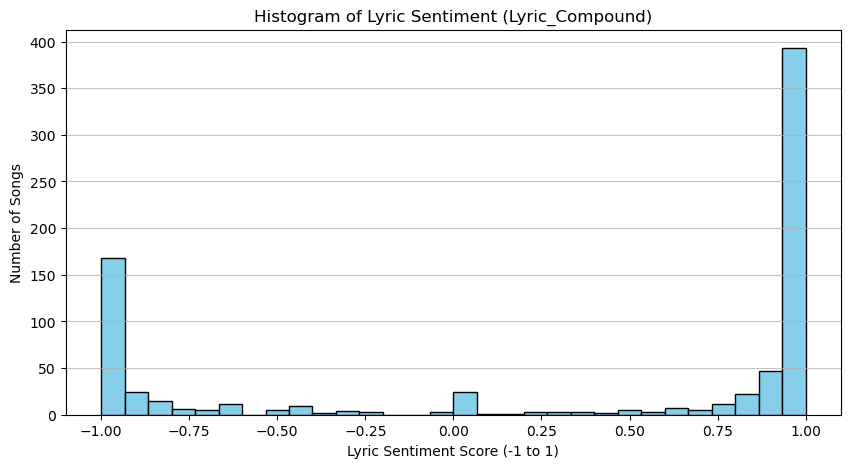

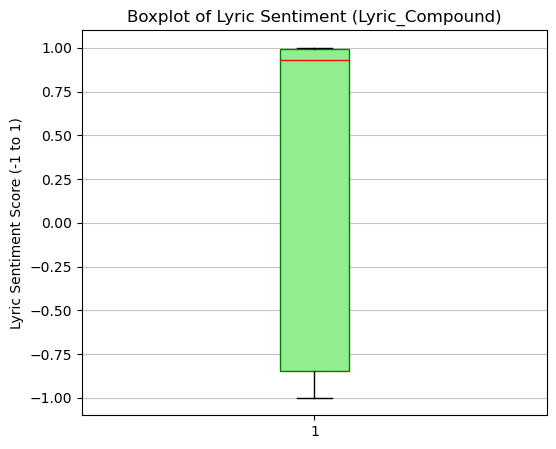

In [6]:
# =======================================
# TASK 3.1: Data Validation Graphic
# =======================================

import pandas as pd
import matplotlib.pyplot as plt


# 1. Load dataset (if not already in memory)
df = pd.read_csv("billboard_with_lyrics_and_sentiment.csv")

# 2. Check for missing values in Lyric_Compound
missing_count = df["Lyric_Compound"].isna().sum()
print(f"Number of songs missing Lyric_Compound: {missing_count}")

# 3. Basic statistics to check for outliers
print("Lyric_Compound statistics:")
print(df["Lyric_Compound"].describe())

# 4. Histogram of lyric sentiment
plt.figure(figsize=(10,5))
plt.hist(df["Lyric_Compound"].dropna(), bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Lyric Sentiment (Lyric_Compound)")
plt.xlabel("Lyric Sentiment Score (-1 to 1)")
plt.ylabel("Number of Songs")
plt.grid(axis='y', alpha=0.75)
plt.show()

# 5. Boxplot of lyric sentiment
plt.figure(figsize=(6,5))
plt.boxplot(df["Lyric_Compound"].dropna(), vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='green'),
            medianprops=dict(color='red'))
plt.title("Boxplot of Lyric Sentiment (Lyric_Compound)")
plt.ylabel("Lyric Sentiment Score (-1 to 1)")
plt.grid(axis='y', alpha=0.75)
plt.show()


**Task 3.2: Aggregation**

  * Group data by year and calculate mean lyric sentiment per year.
  * Optionally, calculate mean sentiment for top 10 songs per year.
  * *Satisfies: Grouping or aggregation task.*

In [9]:
# =======================================
# TASK 3.2: Aggregation
# =======================================

# Ensure 'Year' is datetime
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

# Optional: create top 10 subset
top10_df = df[df["Rank"] <= 10].reset_index(drop=True)

# Aggregate average lyric sentiment per year (all songs)
yearly_sentiment_all = df.groupby(df["Year"].dt.year)["Lyric_Compound"].mean().reset_index()
yearly_sentiment_all.rename(columns={"Lyric_Compound": "Avg_Lyric_Sentiment"}, inplace=True)

# Aggregate average lyric sentiment for top 10 songs per year
yearly_sentiment_top10 = top10_df.groupby(top10_df["Year"].dt.year)["Lyric_Compound"].mean().reset_index()
yearly_sentiment_top10.rename(columns={"Lyric_Compound": "Avg_Lyric_Sentiment"}, inplace=True)

# Quick check
print("Yearly sentiment (all songs):")
print(yearly_sentiment_all)

print("\nYearly sentiment (top 10 songs):")
print(yearly_sentiment_top10)


Yearly sentiment (all songs):
    Year  Avg_Lyric_Sentiment
0   2013             0.449221
1   2014             0.450463
2   2015             0.443290
3   2016             0.353378
4   2017             0.117507
5   2018             0.281736
6   2019             0.326031
7   2020             0.233582
8   2021             0.285999
9   2022             0.295420
10  2023             0.237227

Yearly sentiment (top 10 songs):
    Year  Avg_Lyric_Sentiment
0   2013             0.527238
1   2014             0.290750
2   2015             0.218850
3   2016             0.318083
4   2017             0.004367
5   2018            -0.013640
6   2019            -0.169075
7   2020             0.312325
8   2021             0.318767
9   2022             0.183860
10  2023             0.364910


**Task 3.3: Conclusion Graphic**

  * Plot a line chart (or dual-line if including top 10 vs all songs) showing average lyric sentiment over time.
  * Annotate significant cultural events (e.g., pandemic start in 2020).
  * *Satisfies: Graphic supporting the conclusion.*


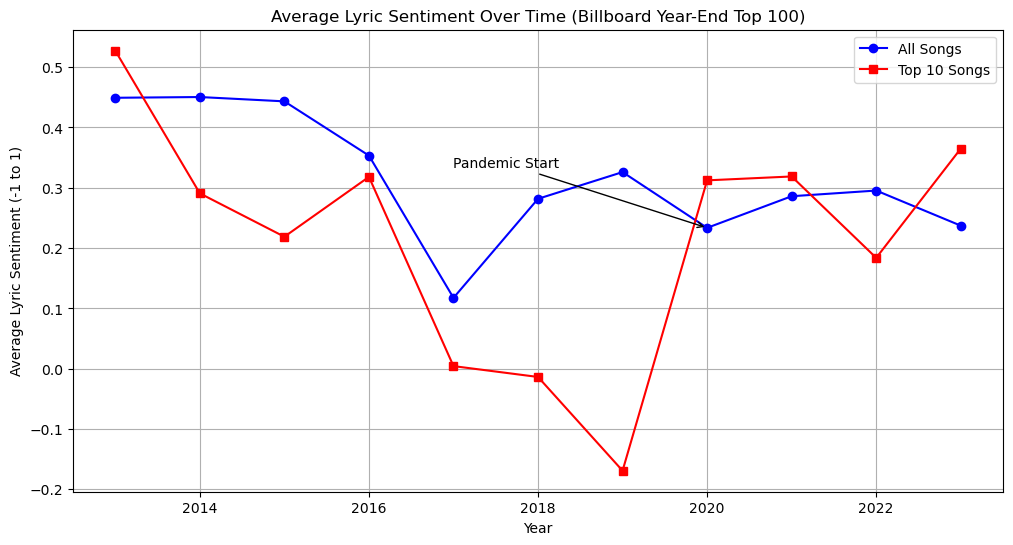

Pearson correlation between Lyric Compound and Rank: 0.043
Final dataset saved as 'billboard_final_dataset.csv'


In [8]:
# =======================================
# DUAL-AXIS VISUALIZATION, CORRELATION, SAVE CSV
# =======================================

import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# 1. Load final dataset (if not already in memory)
# -------------------------------
df = pd.read_csv("billboard_with_lyrics_and_sentiment.csv")

# Ensure Year column is datetime
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

# -------------------------------
# 2. Create top 10 subset
# -------------------------------
top10_df = df[df["Rank"] <= 10].reset_index(drop=True)

# -------------------------------
# 3. Aggregate average lyric sentiment per year
# -------------------------------
yearly_sentiment_all = df.groupby(df["Year"].dt.year)["Lyric_Compound"].mean().reset_index()
yearly_sentiment_all.rename(columns={"Lyric_Compound": "Avg_Lyric_Sentiment"}, inplace=True)

yearly_sentiment_top10 = top10_df.groupby(top10_df["Year"].dt.year)["Lyric_Compound"].mean().reset_index()
yearly_sentiment_top10.rename(columns={"Lyric_Compound": "Avg_Lyric_Sentiment"}, inplace=True)

# -------------------------------
# 4. Dual-axis line chart
# -------------------------------
plt.figure(figsize=(12,6))
plt.plot(yearly_sentiment_all["Year"], yearly_sentiment_all["Avg_Lyric_Sentiment"],
         marker='o', color='blue', label="All Songs")
plt.plot(yearly_sentiment_top10["Year"], yearly_sentiment_top10["Avg_Lyric_Sentiment"],
         marker='s', color='red', label="Top 10 Songs")
plt.title("Average Lyric Sentiment Over Time (Billboard Year-End Top 100)")
plt.xlabel("Year")
plt.ylabel("Average Lyric Sentiment (-1 to 1)")
plt.grid(True)
plt.legend()

# Annotate a cultural event (e.g., Pandemic start)
pandemic_year = 2020
if pandemic_year in yearly_sentiment_all["Year"].values:
    y_val = yearly_sentiment_all.loc[yearly_sentiment_all["Year"]==pandemic_year, "Avg_Lyric_Sentiment"].values[0]
    plt.annotate("Pandemic Start", xy=(pandemic_year, y_val),
                 xytext=(pandemic_year-3, y_val+0.1),
                 arrowprops=dict(facecolor='red', arrowstyle='->'))
plt.show()

# -------------------------------
# 5. Correlation analysis
# -------------------------------
valid_rows = df.dropna(subset=["Lyric_Compound", "Rank"])
correlation = valid_rows["Lyric_Compound"].corr(valid_rows["Rank"])
print(f"Pearson correlation between Lyric Compound and Rank: {correlation:.3f}")

# -------------------------------
# 6. Save final dataset
# -------------------------------
df.to_csv("billboard_final_dataset.csv", index=False)
print("Final dataset saved as 'billboard_final_dataset.csv'")


**Task 3.4: Statistical Analysis**

  * Compute Pearson correlation (or similar) between lyric sentiment and rank or other numeric metrics.
  * *Satisfies: Statistical analysis supporting the conclusion.*


In [10]:
# =======================================
# TASK 3.4: Statistical Analysis
# =======================================

import pandas as pd

# 1. Load dataset if not already in memory
df = pd.read_csv("billboard_with_lyrics_and_sentiment.csv")

# 2. Ensure numeric columns are proper type
df["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")
df["Lyric_Compound"] = pd.to_numeric(df["Lyric_Compound"], errors="coerce")

# 3. Drop rows with missing values for these columns
valid_rows = df.dropna(subset=["Rank", "Lyric_Compound"])

# 4. Compute Pearson correlation
correlation = valid_rows["Lyric_Compound"].corr(valid_rows["Rank"])
print(f"Pearson correlation between Lyric Sentiment and Rank: {correlation:.3f}")

# 5. Optional: interpret
if correlation > 0:
    print("Positive correlation: Higher sentiment scores are associated with higher ranks (numerically larger).")
elif correlation < 0:
    print("Negative correlation: Higher sentiment scores are associated with lower ranks (more popular songs).")
else:
    print("No correlation detected between sentiment and rank.")


Pearson correlation between Lyric Sentiment and Rank: 0.043
Positive correlation: Higher sentiment scores are associated with higher ranks (numerically larger).


### Phase 4: Presentation & Final Polish

**Goal:** Ensure reproducibility and clarity for grading.


**Task 4.1: Reproducibility Check**

  * Save the final cleaned dataset to CSV.
  * Ensure notebook runs top-to-bottom without errors.
  * *Satisfies: Code runs without errors.*


In [11]:
# =======================================
# PHASE 4: Save Final Dataset
# =======================================

import pandas as pd

# 1. Load dataset if not already in memory
df = pd.read_csv("billboard_with_lyrics_and_sentiment.csv")

# 2. Ensure all necessary columns are present
required_columns = ["Rank", "Year", "Title", "Artist", "Lyrics",
                    "Lyric_Neg", "Lyric_Neu", "Lyric_Pos", "Lyric_Compound"]
missing_columns = [col for col in required_columns if col not in df.columns]

if missing_columns:
    raise ValueError(f"Missing required columns: {missing_columns}")

# 3. Convert 'Year' to datetime
df["Year"] = pd.to_datetime(df["Year"], format="%Y")

# 4. Optional: subset top 10 songs (already done in previous cells)
top10_df = df[df["Rank"] <= 10].reset_index(drop=True)

# 5. Save the final dataset
df.to_csv("billboard_final_dataset.csv", index=False)
print(f"Final dataset saved as 'billboard_final_dataset.csv' with {len(df)} rows.")

# 6. Quick validation
print("Columns in final dataset:")
print(df.columns)
print("Sample rows:")
print(df.head())


Final dataset saved as 'billboard_final_dataset.csv' with 1099 rows.
Columns in final dataset:
Index(['Rank', 'Year', 'Title', 'Artist', 'Lyrics', 'Lyric_Neg', 'Lyric_Neu',
       'Lyric_Pos', 'Lyric_Compound'],
      dtype='object')
Sample rows:
   Rank       Year          Title  \
0     1 2013-01-01    Thrift Shop   
1     2 2013-01-01  Blurred Lines   
2     3 2013-01-01    Radioactive   
3     4 2013-01-01   Harlem Shake   
4     5 2013-01-01  Can't Hold Us   

                                        Artist  \
0       Macklemore & Ryan Lewis Featuring Wanz   
1        Robin ThickeFeaturing T.I. + Pharrell   
2                              Imagine Dragons   
3                                       Baauer   
4  Macklemore & Ryan Lewis FeaturingRay Dalton   

                                              Lyrics  Lyric_Neg  Lyric_Neu  \
0  Hey, Macklemore, can we go thrift shopping?\nW...      0.118      0.784   
1                                                NaN        NaN        Na